In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
RESULTS_DIR = f"{TEAMS_DIR}/fairness-analysis-results"

In [2]:
policies = (
    ("Sensitivity", 0.9),
    ("Sensitivity", 1.0),
    ("Specificity", 0.9),
    ("Specificity", 1.0),
    # ("Youden J", 1.0),  ## Max J statistic
)

# Run and save analysis

## DLCST

In [3]:
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.053366,0.082652,0.166209,0
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,0.007835,0.011039,0.018442,0.030460,0.009543,0.000408,0.003368,0
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,0.007835,0.012797,0.019229,0.032957,0.006734,0.002702,0.065888,0
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.007944,0.084158,0.423341,0
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,0.003791,0.006847,0.010381,0.017287,0.000899,0.000013,0.005590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4057,20060314,1.2.840.113704.1.111.4796.1142355218.14,69,1,0,1,2,0.168810,0.273494,0.257961,0.294720,0.327062,0.383196,0.380198,0.893933,0.682322,0
595,4063,20060313,1.2.840.113704.1.111.5104.1142267340.10,55,1,0,1,4,0.001965,0.006793,0.013618,0.017289,0.021685,0.035951,0.000000,0.000099,0.103020,0
596,4079,20060328,1.2.840.113704.1.111.1308.1143556124.11,52,2,0,0,1,0.003951,0.011459,0.025373,0.034010,0.040101,0.058852,0.039054,0.070744,0.121373,0
597,4098,20060403,1.2.840.113704.1.111.5848.1144079789.11,54,1,0,1,3,0.117795,0.167839,0.189976,0.217799,0.229753,0.300137,0.134158,0.452513,0.347016,0


In [4]:
dlcst_democols = {
    'cat': {'demo': ['Sex'], 'other': ['FamilyHistoryLungCa', 'Emphysema']},
    'num': {'demo': ['Age'], 'other': ['NoduleCountPerScan']}
}

In [5]:
dlcst_preds, dlcst_democols = data.bin_numerical_columns(dlcst_preds, dlcst_democols)
dlcst_democols

{'cat': {'demo': ['Age > 61', 'Sex'],
  'other': ['Emphysema', 'FamilyHistoryLungCa', 'NoduleCountPerScan > 1']},
 'num': {'demo': ['Age'], 'other': ['NoduleCountPerScan']}}

In [6]:
DLCST_MODELCOLS = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "PanCan2b": "PanCan2b",
    "Sybil year 1": "sybil_year1",
    # "Sybil year 2": "sybil_year2",
    # "Sybil year 3": "sybil_year3",
    # "Sybil year 4": "sybil_year4",
    # "Sybil year 5": "sybil_year5",
    # "Sybil year 6": "sybil_year6",
}

In [7]:
result_df = roc.all_results_subgroups_models(dlcst_preds, dlcst_democols['cat'], models=DLCST_MODELCOLS, csvpath=f"{RESULTS_DIR}/auroc-dlcst-{len(dlcst_preds)}.csv")
result_df

,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_ben,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,attribute,category
Venkadesh,0.909707,0.113408,True,0.923066,0.868841,0.969003,False,0.928394,0.877238,0.970634,...,133,27.378965,18.902439,28,407,72.621035,6.436782,Ensemble_Kiran,Age > 61,demo
de Haas,0.68605,0.404221,True,0.912013,0.860069,0.964839,False,0.931365,0.887097,0.97577,...,133,27.378965,18.902439,28,407,72.621035,6.436782,thijmen_mean,Age > 61,demo
PanCan2b,0.419335,0.807575,True,0.851815,0.792921,0.915105,False,0.898209,0.841399,0.945332,...,133,27.378965,18.902439,28,407,72.621035,6.436782,PanCan2b,Age > 61,demo
Sybil year 1,0.928492,0.089743,True,0.860758,0.78427,0.930278,False,0.866137,0.785758,0.923974,...,133,27.378965,18.902439,28,407,72.621035,6.436782,sybil_year1,Age > 61,demo
Venkadesh,0.437917,0.775716,1.0,0.908254,0.837521,0.970516,2.0,0.944307,0.908594,0.968446,...,291,53.923205,9.907121,27,249,46.076795,9.782609,Ensemble_Kiran,Sex,demo
de Haas,0.353367,0.928078,1.0,0.90296,0.839925,0.965447,2.0,0.946357,0.913565,0.974769,...,291,53.923205,9.907121,27,249,46.076795,9.782609,thijmen_mean,Sex,demo
PanCan2b,0.35083,-0.932981,1.0,0.909613,0.85165,0.953015,2.0,0.856363,0.792547,0.90008,...,291,53.923205,9.907121,27,249,46.076795,9.782609,PanCan2b,Sex,demo
Sybil year 1,0.88113,-0.149537,1.0,0.866212,0.77639,0.946607,2.0,0.857134,0.782818,0.922584,...,291,53.923205,9.907121,27,249,46.076795,9.782609,sybil_year1,Sex,demo
Venkadesh,0.210925,1.251025,1.0,0.91071,0.853562,0.954101,0.0,0.965888,0.940037,0.988043,...,361,67.612688,10.864198,15,179,32.387312,7.731959,Ensemble_Kiran,Emphysema,other
de Haas,0.508438,0.661272,1.0,0.915596,0.866233,0.960734,0.0,0.948117,0.902625,0.978142,...,361,67.612688,10.864198,15,179,32.387312,7.731959,thijmen_mean,Emphysema,other


In [9]:
result_df[['p', 'AUC_diff']]

,p,AUC_diff
Venkadesh,0.909707,0.005328
de Haas,0.68605,0.019351
PanCan2b,0.419335,0.046394
Sybil year 1,0.928492,0.005379
Venkadesh,0.437917,0.036053
de Haas,0.353367,0.043397
PanCan2b,0.35083,-0.053249
Sybil year 1,0.88113,-0.009079
Venkadesh,0.210925,0.055177
de Haas,0.508438,0.03252


### Thresholds

In [8]:
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=DLCST_MODELCOLS, policies=policies, brock=True)
df = threshold.all_results_subgroups_models(dlcst_preds, dlcst_democols['cat'], policies=dlcst_policies, models=DLCST_MODELCOLS, csvpath=f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', plot=False)
df

KeyboardInterrupt: 

,num,pct,mal,ben,pct_mal
1,323,53.923205,32,291,9.907121
2,276,46.076795,27,249,9.782609


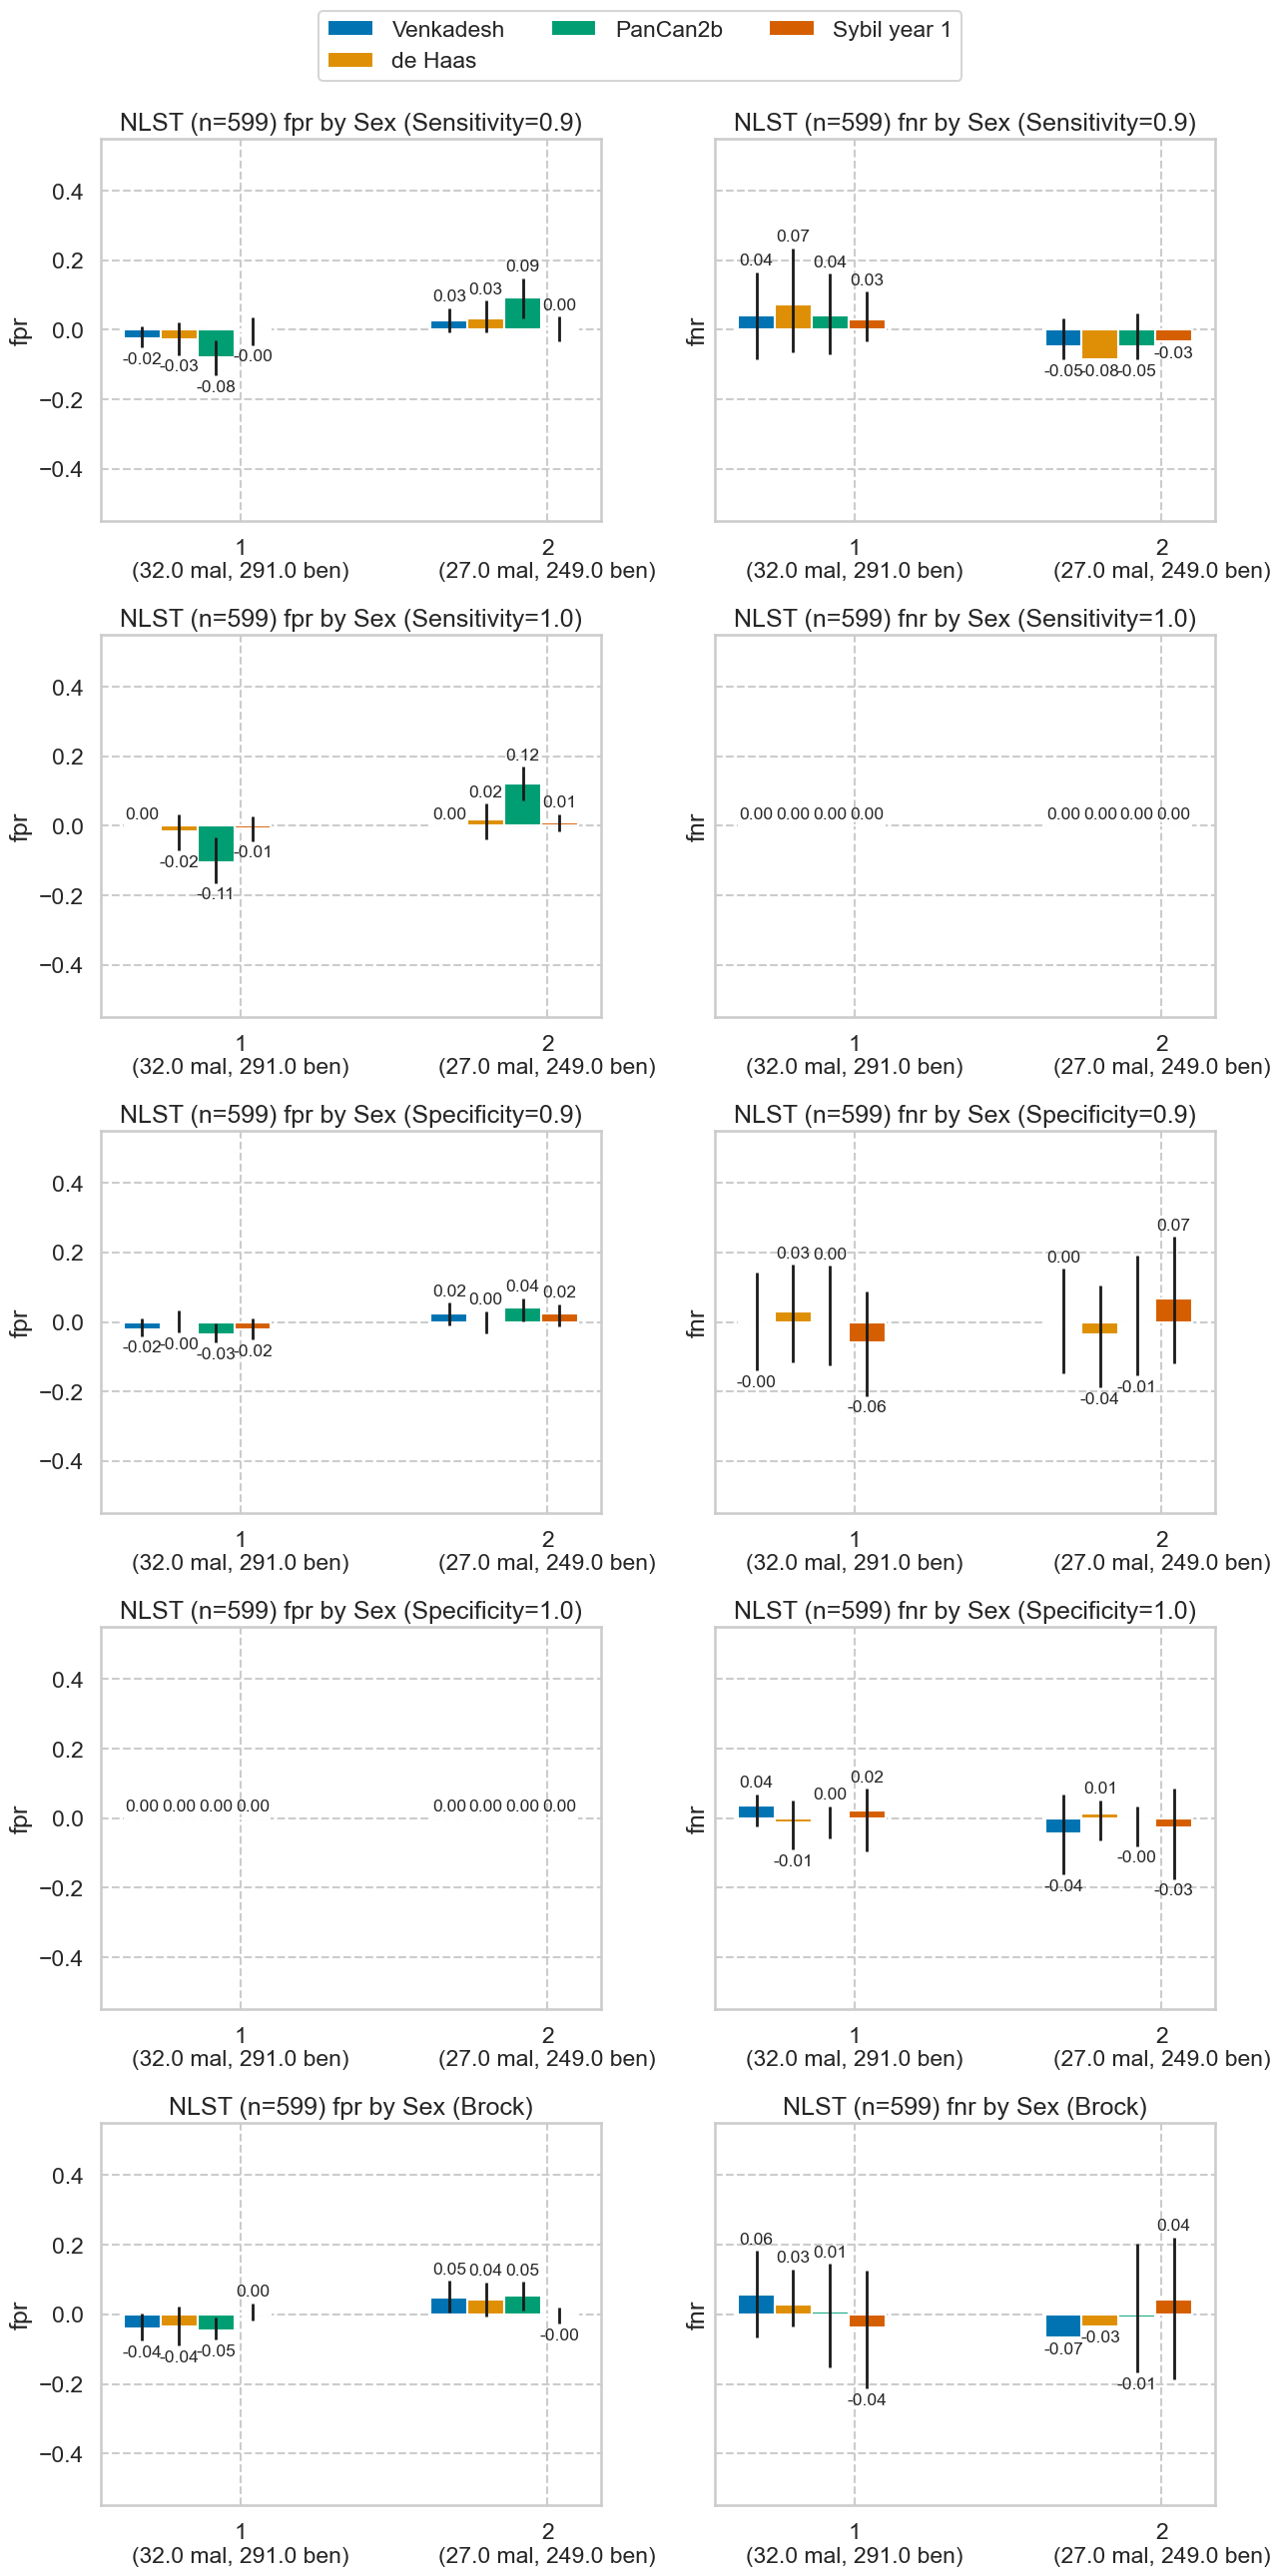

,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,...,for_hi,acc_hi,j_hi,f1_hi,mcc_hi,threshold_hi,iter_hi,col,attribute,category
0,599.0,59.0,540.0,54.0,76.0,464.0,5.0,0.915254,0.140741,0.084746,...,0.019013,0.894032,0.856102,0.646050,0.635866,0.001,96.525,Ensemble_Kiran,Sex,demo
1,599.0,59.0,540.0,54.0,119.0,421.0,5.0,0.915254,0.220370,0.084746,...,0.019993,0.820576,0.775065,0.530461,0.511453,0.001,96.525,thijmen_mean,Sex,demo
2,599.0,59.0,540.0,54.0,160.0,380.0,5.0,0.915254,0.296296,0.084746,...,0.024848,0.758806,0.696765,0.459896,0.442689,0.001,96.525,PanCan2b,Sex,demo
3,599.0,59.0,540.0,57.0,453.0,87.0,2.0,0.966102,0.838889,0.033898,...,0.048173,0.272204,0.175595,0.240617,0.147432,0.001,96.525,sybil_year1,Sex,demo
4,599.0,59.0,540.0,59.0,540.0,0.0,0.0,1.000000,1.000000,0.000000,...,NaN,0.117738,0.000000,0.210671,NaN,0.000,96.525,Ensemble_Kiran,Sex,demo
5,599.0,59.0,540.0,59.0,430.0,110.0,0.0,1.000000,0.796296,0.000000,...,0.000000,0.324750,0.240490,0.255178,0.183780,0.000,96.525,thijmen_mean,Sex,demo
6,599.0,59.0,540.0,59.0,363.0,177.0,0.0,1.000000,0.672222,0.000000,...,0.000000,0.431678,0.372483,0.286668,0.244268,0.000,96.525,PanCan2b,Sex,demo
7,599.0,59.0,540.0,59.0,492.0,48.0,0.0,1.000000,0.911111,0.000000,...,0.000000,0.207888,0.110803,0.226705,0.114704,0.000,96.525,sybil_year1,Sex,demo
8,599.0,59.0,540.0,46.0,54.0,486.0,13.0,0.779661,0.100000,0.220339,...,0.036703,0.911519,0.790842,0.655080,0.628805,0.018,96.525,Ensemble_Kiran,Sex,demo
9,599.0,59.0,540.0,46.0,54.0,486.0,13.0,0.779661,0.100000,0.220339,...,0.038966,0.911519,0.801871,0.666667,0.636548,0.018,96.525,thijmen_mean,Sex,demo


In [ ]:
# threshold.plot_threshold_stats_subgroups(dlcst_preds, 'Sex', policies=dlcst_policies, models=DLCST_MODELCOLS, stats=df.query('attribute == "Sex"'), plot_metrics=['fpr', 'fnr'], diff=True)

## NLST

In [ ]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")

with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_original = json.load(json_data)
    json_data.close()

nlst_democols_original['cat'].pop('lungcanc')
nlst_democols_original

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

### Nodule-level

In [ ]:
nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=False, tijmen=False, sybil=False)
print(len(nlst_preds), " nodules")

result_df = roc.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], models=MODELS, csvpath=f"{RESULTS_DIR}/auroc-nlst-{len(nlst_preds)}.csv")
result_df

16077  nodules


KeyboardInterrupt: 

In [ ]:
nlst_policies, _ = threshold.get_threshold_policies(nlst_preds, models=MODELS, policies=policies, brock=True)
df = threshold.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], policies=nlst_policies, models=MODELS, csvpath=f'{RESULTS_DIR}/threshold-perfs-nlst-{len(nlst_preds)}.csv', plot=False)
df

,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,...,for_hi,acc_hi,j_hi,f1_hi,mcc_hi,threshold_hi,iter_hi,col,attribute,category
0,16077.0,1249.0,14828.0,1127.0,3895.0,10933.0,122.0,0.902322,0.262679,0.097678,...,0.013119,0.756192,0.657656,0.377408,0.382883,0.015,96.525,DL_cal,Age > 61,demo
1,16077.0,1249.0,14828.0,1125.0,4211.0,10617.0,124.0,0.900721,0.283990,0.099279,...,0.013514,0.738076,0.633762,0.359629,0.366843,0.015,96.525,Thijmen_local_cal,Age > 61,demo
2,16077.0,1249.0,14828.0,1125.0,4766.0,10062.0,124.0,0.900721,0.321419,0.099279,...,0.014025,0.702755,0.596217,0.329809,0.333348,0.015,96.525,Thijmen_global_hidden_cal,Age > 61,demo
3,16077.0,1249.0,14828.0,1126.0,4262.0,10566.0,123.0,0.901521,0.287429,0.098479,...,0.014372,0.733826,0.630934,0.355944,0.363916,0.015,96.525,Thijmen_global_show_cal,Age > 61,demo
4,16077.0,1249.0,14828.0,1131.0,6401.0,8427.0,118.0,0.905524,0.431683,0.094476,...,0.016517,0.602045,0.491786,0.273244,0.267184,0.015,96.525,PanCan2b,Age > 61,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,3217.0,181.0,3036.0,159.0,602.0,2434.0,22.0,0.878453,0.198287,0.121547,...,0.012436,0.818643,0.724928,0.378364,0.406527,0.060,96.525,DL_cal,ManufacturersModelName,scanner
571,3217.0,181.0,3036.0,152.0,685.0,2351.0,29.0,0.839779,0.225626,0.160221,...,0.016615,0.791584,0.671139,0.331071,0.354145,0.060,96.525,Thijmen_local_cal,ManufacturersModelName,scanner
572,3217.0,181.0,3036.0,168.0,969.0,2067.0,13.0,0.928177,0.319170,0.071823,...,0.010277,0.709535,0.642404,0.283327,0.317331,0.060,96.525,Thijmen_global_hidden_cal,ManufacturersModelName,scanner
573,3217.0,181.0,3036.0,161.0,741.0,2295.0,20.0,0.889503,0.244071,0.110497,...,0.012942,0.779950,0.695579,0.332455,0.368167,0.060,96.525,Thijmen_global_show_cal,ManufacturersModelName,scanner


In [ ]:
nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=False, tijmen=True, sybil=False)
print(len(nlst_preds), " nodules")

result_df = roc.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], models=MODELS, csvpath=f"{RESULTS_DIR}/auroc-nlst-{len(nlst_preds)}.csv")
result_df

3240  nodules


,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_ben,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,attribute,category
Venkadesh,0.707049,0.375823,True,0.893352,0.870166,0.916681,False,0.903191,0.876564,0.930569,...,1755,60.061728,9.815005,90,1204,39.938272,6.955178,DL_cal,Age > 61,demo
de Haas Combined,0.430028,-0.789144,True,0.912424,0.891279,0.928096,False,0.891621,0.858668,0.917424,...,1755,60.061728,9.815005,90,1204,39.938272,6.955178,Thijmen_mean_cal,Age > 61,demo
de Haas Local,0.864296,-0.170908,True,0.902554,0.871822,0.921766,False,0.898068,0.867164,0.925,...,1755,60.061728,9.815005,90,1204,39.938272,6.955178,Thijmen_local_cal,Age > 61,demo
de Haas Global (hidden nodule),0.219168,-1.228745,True,0.868102,0.847911,0.887411,False,0.829904,0.79735,0.860646,...,1755,60.061728,9.815005,90,1204,39.938272,6.955178,Thijmen_global_hidden_cal,Age > 61,demo
de Haas Global (shown nodule),0.106383,-1.614666,True,0.899443,0.877871,0.921754,False,0.852356,0.820349,0.884129,...,1755,60.061728,9.815005,90,1204,39.938272,6.955178,Thijmen_global_show_cal,Age > 61,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de Haas Combined,0.560479,-0.58213,LightSpeed QX/i,0.916476,0.884431,0.947395,Volume Zoom,0.892479,0.832905,0.933642,...,437,15.308642,11.895161,41,599,19.753086,6.406250,Thijmen_mean_cal,ManufacturersModelName,scanner
de Haas Local,0.237697,-1.180764,LightSpeed QX/i,0.917535,0.887045,0.947729,Volume Zoom,0.866135,0.794973,0.918767,...,437,15.308642,11.895161,41,599,19.753086,6.406250,Thijmen_local_cal,ManufacturersModelName,scanner
de Haas Global (hidden nodule),0.668197,-0.428624,LightSpeed QX/i,0.887629,0.858198,0.919354,Volume Zoom,0.868213,0.830912,0.905542,...,437,15.308642,11.895161,41,599,19.753086,6.406250,Thijmen_global_hidden_cal,ManufacturersModelName,scanner
de Haas Global (shown nodule),0.595375,-0.531063,LightSpeed QX/i,0.922275,0.89482,0.944243,Volume Zoom,0.901086,0.859262,0.937322,...,437,15.308642,11.895161,41,599,19.753086,6.406250,Thijmen_global_show_cal,ManufacturersModelName,scanner


In [ ]:
nlst_policies, _ = threshold.get_threshold_policies(nlst_preds, models=MODELS, policies=policies, brock=True)
df = threshold.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], policies=nlst_policies, models=MODELS, csvpath=f'{RESULTS_DIR}/threshold-perfs-nlst-{len(nlst_preds)}.csv', plot=False)
df

,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,...,for_hi,acc_hi,j_hi,f1_hi,mcc_hi,threshold_hi,iter_hi,col,attribute,category
0,3240.0,281.0,2959.0,253.0,906.0,2053.0,28.0,0.900356,0.306185,0.099644,...,0.018407,0.727631,0.632689,0.382212,0.379125,0.015,96.525,DL_cal,Age > 61,demo
1,3240.0,281.0,2959.0,253.0,747.0,2212.0,28.0,0.900356,0.252450,0.099644,...,0.018071,0.777323,0.689194,0.437444,0.427916,0.015,96.525,Thijmen_mean_cal,Age > 61,demo
2,3240.0,281.0,2959.0,253.0,767.0,2192.0,28.0,0.900356,0.259209,0.099644,...,0.017106,0.770139,0.678942,0.420589,0.418319,0.015,96.525,Thijmen_local_cal,Age > 61,demo
3,3240.0,281.0,2959.0,253.0,969.0,1990.0,28.0,0.900356,0.327475,0.099644,...,0.018583,0.710864,0.609942,0.373861,0.364312,0.015,96.525,Thijmen_global_hidden_cal,Age > 61,demo
4,3240.0,281.0,2959.0,253.0,944.0,2015.0,28.0,0.900356,0.319027,0.099644,...,0.019754,0.716258,0.612000,0.380650,0.369884,0.015,96.525,Thijmen_global_show_cal,Age > 61,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,640.0,41.0,599.0,37.0,162.0,437.0,4.0,0.902439,0.270451,0.097561,...,0.015463,0.775000,0.730772,0.377994,0.405245,0.060,96.525,Thijmen_mean_cal,ManufacturersModelName,scanner
566,640.0,41.0,599.0,33.0,142.0,457.0,8.0,0.804878,0.237062,0.195122,...,0.027604,0.790625,0.684682,0.368989,0.382815,0.060,96.525,Thijmen_local_cal,ManufacturersModelName,scanner
567,640.0,41.0,599.0,39.0,184.0,415.0,2.0,0.951220,0.307179,0.048780,...,0.012022,0.744570,0.707918,0.354671,0.382274,0.060,96.525,Thijmen_global_hidden_cal,ManufacturersModelName,scanner
568,640.0,41.0,599.0,36.0,138.0,461.0,5.0,0.878049,0.230384,0.121951,...,0.021348,0.806250,0.755717,0.406872,0.427357,0.060,96.525,Thijmen_global_show_cal,ManufacturersModelName,scanner


### Scan-level

In [ ]:
nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=True, tijmen=False, sybil=True)
print(len(nlst_preds), " scans")

result_df = roc.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], models=MODELS, csvpath=f"{RESULTS_DIR}/auroc-nlst-{len(nlst_preds)}.csv")
result_df

5911  scans


,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_ben,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,attribute,category
Venkadesh,0.132657,1.503707,True,0.87811,0.858441,0.893875,False,0.904852,0.891247,0.930911,...,2967,56.251057,10.766917,223,2363,43.748943,8.623357,DL_cal,Age > 61,demo
de Haas Local,0.328817,0.9765,True,0.864697,0.846223,0.884755,False,0.883209,0.857003,0.908854,...,2967,56.251057,10.766917,223,2363,43.748943,8.623357,Thijmen_local_cal,Age > 61,demo
de Haas Global (hidden nodule),0.275042,1.091525,True,0.786413,0.76672,0.808836,False,0.81069,0.786524,0.836693,...,2967,56.251057,10.766917,223,2363,43.748943,8.623357,Thijmen_global_hidden_cal,Age > 61,demo
de Haas Global (shown nodule),0.589268,-0.539898,True,0.857046,0.845183,0.876881,False,0.84607,0.818877,0.86718,...,2967,56.251057,10.766917,223,2363,43.748943,8.623357,Thijmen_global_show_cal,Age > 61,demo
Sybil year 1,0.697378,0.388863,True,0.837847,0.813851,0.857848,False,0.845886,0.814478,0.877089,...,2967,56.251057,10.766917,223,2363,43.748943,8.623357,sybil_year1,Age > 61,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de Haas Local,0.967376,0.0409,Volume Zoom,0.885999,0.846497,0.924116,Sensation 16,0.887243,0.849386,0.917924,...,1204,22.128235,7.951070,96,719,13.787853,11.779141,Thijmen_local_cal,ManufacturersModelName,scanner
de Haas Global (hidden nodule),0.951275,-0.061105,Volume Zoom,0.805651,0.769375,0.836721,Sensation 16,0.803406,0.767096,0.844879,...,1204,22.128235,7.951070,96,719,13.787853,11.779141,Thijmen_global_hidden_cal,ManufacturersModelName,scanner
de Haas Global (shown nodule),0.488925,-0.69202,Volume Zoom,0.872788,0.837737,0.9042,Sensation 16,0.85009,0.809006,0.882188,...,1204,22.128235,7.951070,96,719,13.787853,11.779141,Thijmen_global_show_cal,ManufacturersModelName,scanner
Sybil year 1,0.258734,-1.129388,Volume Zoom,0.884241,0.851066,0.9096,Sensation 16,0.847677,0.803974,0.891938,...,1204,22.128235,7.951070,96,719,13.787853,11.779141,sybil_year1,ManufacturersModelName,scanner


In [ ]:
nlst_policies, _ = threshold.get_threshold_policies(nlst_preds, models=MODELS, policies=policies, brock=True)
df = threshold.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], policies=nlst_policies, models=MODELS, csvpath=f'{RESULTS_DIR}/threshold-perfs-nlst-{len(nlst_preds)}.csv', plot=False)
df

,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,...,for_hi,acc_hi,j_hi,f1_hi,mcc_hi,threshold_hi,iter_hi,col,attribute,category
0,5911.0,581.0,5330.0,523.0,1807.0,3523.0,58.0,0.900172,0.339024,0.099828,...,0.020002,0.694075,0.582875,0.381759,0.361279,0.015,96.525,DL_cal,Age > 61,demo
1,5911.0,581.0,5330.0,525.0,2095.0,3235.0,56.0,0.903614,0.393058,0.096386,...,0.021105,0.649074,0.533807,0.347459,0.321500,0.015,96.525,Thijmen_local_cal,Age > 61,demo
2,5911.0,581.0,5330.0,523.0,2475.0,2855.0,58.0,0.900172,0.464353,0.099828,...,0.024868,0.584216,0.460402,0.312384,0.277062,0.015,96.525,Thijmen_global_hidden_cal,Age > 61,demo
3,5911.0,581.0,5330.0,523.0,2059.0,3271.0,58.0,0.900172,0.386304,0.099828,...,0.021863,0.652859,0.535537,0.354574,0.327465,0.015,96.525,Thijmen_global_show_cal,Age > 61,demo
4,5911.0,581.0,5330.0,527.0,2644.0,2686.0,54.0,0.907057,0.496060,0.092943,...,0.024953,0.553836,0.433602,0.298880,0.258836,0.015,96.525,sybil_year1,Age > 61,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,1308.0,104.0,1204.0,90.0,368.0,836.0,14.0,0.865385,0.305648,0.134615,...,0.027247,0.733983,0.632650,0.369934,0.364312,0.060,96.525,Thijmen_local_cal,ManufacturersModelName,scanner
656,1308.0,104.0,1204.0,96.0,572.0,632.0,8.0,0.923077,0.475083,0.076923,...,0.020906,0.583085,0.499299,0.288997,0.283032,0.060,96.525,Thijmen_global_hidden_cal,ManufacturersModelName,scanner
657,1308.0,104.0,1204.0,94.0,431.0,773.0,10.0,0.903846,0.357973,0.096154,...,0.020930,0.686984,0.604073,0.342343,0.346710,0.060,96.525,Thijmen_global_show_cal,ManufacturersModelName,scanner
658,1308.0,104.0,1204.0,65.0,87.0,1117.0,39.0,0.625000,0.072259,0.375000,...,0.043232,0.919763,0.636749,0.574098,0.537821,0.060,96.525,sybil_year1,ManufacturersModelName,scanner


In [ ]:
nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=True, tijmen=True, sybil=True)
print(len(nlst_preds), " scans")

result_df = roc.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], models=MODELS, csvpath=f"{RESULTS_DIR}/auroc-nlst-{len(nlst_preds)}.csv", plot=False)
result_df

1172  scans


,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_ben,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,attribute,category
Venkadesh,0.215231,1.239309,True,0.835031,0.785714,0.874194,False,0.886407,0.840167,0.933685,...,591,57.081911,11.659193,49,454,42.918089,9.741551,DL_cal,Age > 61,demo
de Haas Combined,0.727101,0.348985,True,0.862578,0.832523,0.89897,False,0.876914,0.830161,0.916705,...,591,57.081911,11.659193,49,454,42.918089,9.741551,Thijmen_mean_cal,Age > 61,demo
de Haas Local,0.458206,0.741804,True,0.855036,0.813509,0.901065,False,0.885268,0.827847,0.933729,...,591,57.081911,11.659193,49,454,42.918089,9.741551,Thijmen_local_cal,Age > 61,demo
de Haas Global (hidden nodule),0.849725,-0.189469,True,0.773673,0.734545,0.811233,False,0.764294,0.711086,0.819779,...,591,57.081911,11.659193,49,454,42.918089,9.741551,Thijmen_global_hidden_cal,Age > 61,demo
de Haas Global (shown nodule),0.849385,0.189903,True,0.814697,0.779275,0.851349,False,0.823457,0.769289,0.878068,...,591,57.081911,11.659193,49,454,42.918089,9.741551,Thijmen_global_show_cal,Age > 61,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de Haas Local,0.565975,0.573989,Volume Zoom,0.832588,0.767969,0.888418,Sensation 16,0.871221,0.790756,0.946479,...,233,22.696246,12.406015,19,138,13.395904,12.101911,Thijmen_local_cal,ManufacturersModelName,scanner
de Haas Global (hidden nodule),0.685043,-0.405592,Volume Zoom,0.814943,0.759566,0.867754,Sensation 16,0.784298,0.716792,0.86211,...,233,22.696246,12.406015,19,138,13.395904,12.101911,Thijmen_global_hidden_cal,ManufacturersModelName,scanner
de Haas Global (shown nodule),0.185487,-1.324048,Volume Zoom,0.866543,0.814904,0.918615,Sensation 16,0.768761,0.655702,0.878151,...,233,22.696246,12.406015,19,138,13.395904,12.101911,Thijmen_global_show_cal,ManufacturersModelName,scanner
Sybil year 1,0.434555,-0.781422,Volume Zoom,0.873205,0.813825,0.923301,Sensation 16,0.818425,0.709909,0.908784,...,233,22.696246,12.406015,19,138,13.395904,12.101911,sybil_year1,ManufacturersModelName,scanner


In [ ]:
nlst_policies, _ = threshold.get_threshold_policies(nlst_preds, models=MODELS, policies=policies, brock=True)
df = threshold.all_results_subgroups_models(nlst_preds, nlst_democols['cat'], policies=nlst_policies, models=MODELS, csvpath=f'{RESULTS_DIR}/threshold-perfs-nlst-{len(nlst_preds)}.csv', plot=False)
df

,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,...,for_hi,acc_hi,j_hi,f1_hi,mcc_hi,threshold_hi,iter_hi,col,attribute,category
0,1172.0,127.0,1045.0,115.0,485.0,560.0,12.0,0.905512,0.464115,0.094488,...,0.030374,0.600363,0.488699,0.361121,0.314432,0.014,96.525,DL_cal,Age > 61,demo
1,1172.0,127.0,1045.0,115.0,381.0,664.0,12.0,0.905512,0.364593,0.094488,...,0.026775,0.688161,0.590005,0.417927,0.385184,0.014,96.525,Thijmen_mean_cal,Age > 61,demo
2,1172.0,127.0,1045.0,115.0,405.0,640.0,12.0,0.905512,0.387560,0.094488,...,0.028749,0.670243,0.558836,0.399103,0.360079,0.014,96.525,Thijmen_local_cal,Age > 61,demo
3,1172.0,127.0,1045.0,115.0,506.0,539.0,12.0,0.905512,0.484211,0.094488,...,0.034305,0.584151,0.483782,0.352381,0.303206,0.014,96.525,Thijmen_global_hidden_cal,Age > 61,demo
4,1172.0,127.0,1045.0,115.0,503.0,542.0,12.0,0.905512,0.481340,0.094488,...,0.033157,0.595371,0.480046,0.355675,0.312717,0.014,96.525,Thijmen_global_show_cal,Age > 61,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,266.0,33.0,233.0,28.0,85.0,148.0,5.0,0.848485,0.364807,0.151515,...,0.066281,0.714286,0.621962,0.465930,0.414174,0.060,96.525,Thijmen_local_cal,ManufacturersModelName,scanner
591,266.0,33.0,233.0,31.0,106.0,127.0,2.0,0.939394,0.454936,0.060606,...,0.036145,0.652350,0.571598,0.474179,0.409343,0.060,96.525,Thijmen_global_hidden_cal,ManufacturersModelName,scanner
592,266.0,33.0,233.0,30.0,77.0,156.0,3.0,0.909091,0.330472,0.090909,...,0.038247,0.761372,0.700385,0.530836,0.484515,0.060,96.525,Thijmen_global_show_cal,ManufacturersModelName,scanner
593,266.0,33.0,233.0,18.0,21.0,212.0,15.0,0.545455,0.090129,0.454545,...,0.102947,0.896711,0.644498,0.647273,0.576743,0.060,96.525,sybil_year1,ManufacturersModelName,scanner


### Gender, isolating other columns

In [ ]:
nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=True, tijmen=False, sybil=True)
print(len(nlst_preds), " scans")
gender_df = roc.save_results_isolate_confounders(nlst_preds, 'Gender', nlst_democols['cat'], MODELS, csvpath=f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-{len(nlst_preds)}.csv')

5911  scans


In [ ]:
gender_df

,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,filter_by,filter_val,category
Venkadesh,0.826538,-0.219144,1.0,0.904856,0.873717,0.928587,2.0,0.898891,0.870847,0.927051,...,56.496520,7.871321,108,1017,43.503480,9.600000,DL_cal,Age > 61,0.0,demo
de Haas Local,0.516926,0.648091,1.0,0.873275,0.838950,0.907319,2.0,0.892182,0.860265,0.924237,...,56.496520,7.871321,108,1017,43.503480,9.600000,Thijmen_local_cal,Age > 61,0.0,demo
de Haas Global (hidden nodule),0.012324,-2.502725,1.0,0.849852,0.820780,0.876430,2.0,0.763553,0.721837,0.801176,...,56.496520,7.871321,108,1017,43.503480,9.600000,Thijmen_global_hidden_cal,Age > 61,0.0,demo
de Haas Global (shown nodule),0.334161,-0.965766,1.0,0.862462,0.834613,0.895286,2.0,0.831350,0.794623,0.865408,...,56.496520,7.871321,108,1017,43.503480,9.600000,Thijmen_global_show_cal,Age > 61,0.0,demo
Sybil year 1,0.000284,3.629623,1.0,0.788297,0.744108,0.831732,2.0,0.902895,0.868808,0.932824,...,56.496520,7.871321,108,1017,43.503480,9.600000,sybil_year1,Age > 61,0.0,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de Haas Local,0.374376,0.888305,1.0,0.871527,0.823735,0.921551,2.0,0.908643,0.850784,0.947086,...,60.321101,7.731305,43,476,39.678899,8.285164,Thijmen_local_cal,ManufacturersModelName,Volume Zoom,scanner
de Haas Global (hidden nodule),0.626125,-0.487187,1.0,0.816371,0.766183,0.854038,2.0,0.790967,0.726665,0.840292,...,60.321101,7.731305,43,476,39.678899,8.285164,Thijmen_global_hidden_cal,ManufacturersModelName,Volume Zoom,scanner
de Haas Global (shown nodule),0.301521,1.033178,1.0,0.854903,0.812163,0.899831,2.0,0.899883,0.839116,0.938676,...,60.321101,7.731305,43,476,39.678899,8.285164,Thijmen_global_show_cal,ManufacturersModelName,Volume Zoom,scanner
Sybil year 1,0.049442,1.964758,1.0,0.851001,0.795125,0.896592,2.0,0.930812,0.897401,0.965416,...,60.321101,7.731305,43,476,39.678899,8.285164,sybil_year1,ManufacturersModelName,Volume Zoom,scanner


In [ ]:
nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=True, tijmen=False, sybil=True)
print(len(nlst_preds), " scans")
race_df = roc.save_results_isolate_confounders(nlst_preds, 'WhiteOrBlack', nlst_democols['cat'], MODELS, csvpath=f'{RESULTS_DIR}/auroc-race-by-factors-nlst-{len(nlst_preds)}.csv')
race_df

In [ ]:
nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=True, tijmen=False, sybil=True)
print(len(nlst_preds), " scans")
overweight_df = roc.save_results_isolate_confounders(nlst_preds, 'Overweight', nlst_democols['cat'], MODELS, csvpath=f'{RESULTS_DIR}/auroc-overweight-by-factors-nlst-{len(nlst_preds)}.csv')
overweight_df

5911  scans


,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,filter_by,filter_val,category
Venkadesh,0.312171,-1.010677,True,0.911889,0.89031,0.933754,False,0.882047,0.843801,0.914601,...,68.561485,8.178229,78,735,31.438515,9.594096,DL_cal,Age > 61,0.0,demo
de Haas Local,0.547978,-0.600792,True,0.888032,0.859378,0.917125,False,0.869247,0.835829,0.912426,...,68.561485,8.178229,78,735,31.438515,9.594096,Thijmen_local_cal,Age > 61,0.0,demo
de Haas Global (hidden nodule),0.436862,0.777503,True,0.798487,0.770461,0.825363,False,0.826324,0.792832,0.86068,...,68.561485,8.178229,78,735,31.438515,9.594096,Thijmen_global_hidden_cal,Age > 61,0.0,demo
de Haas Global (shown nodule),0.154881,-1.4225,True,0.858227,0.831417,0.882521,False,0.808242,0.766975,0.868454,...,68.561485,8.178229,78,735,31.438515,9.594096,Thijmen_global_show_cal,Age > 61,0.0,demo
Sybil year 1,0.551214,-0.595942,True,0.852708,0.815724,0.88055,False,0.832268,0.775725,0.879365,...,68.561485,8.178229,78,735,31.438515,9.594096,sybil_year1,Age > 61,0.0,demo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de Haas Local,0.599263,-0.525461,True,0.891164,0.843099,0.932418,False,0.867989,0.813243,0.915081,...,69.189602,6.740331,43,360,30.810398,10.669975,Thijmen_local_cal,ManufacturersModelName,Volume Zoom,scanner
de Haas Global (hidden nodule),0.225398,-1.212298,True,0.83015,0.771249,0.86963,False,0.766618,0.705749,0.828233,...,69.189602,6.740331,43,360,30.810398,10.669975,Thijmen_global_hidden_cal,ManufacturersModelName,Volume Zoom,scanner
de Haas Global (shown nodule),0.299416,-1.037686,True,0.887777,0.847273,0.917791,False,0.839773,0.785541,0.882102,...,69.189602,6.740331,43,360,30.810398,10.669975,Thijmen_global_show_cal,ManufacturersModelName,Volume Zoom,scanner
Sybil year 1,0.305886,-1.023892,True,0.898525,0.843861,0.935893,False,0.852694,0.794102,0.904593,...,69.189602,6.740331,43,360,30.810398,10.669975,sybil_year1,ManufacturersModelName,Volume Zoom,scanner


# Load results DataFrames

### DLCST

No significant demographic biases.

In [ ]:
dataset_name, dataset_len = 'dlcst', 599
filename = f"{RESULTS_DIR}/auroc-{dataset_name}-{dataset_len}.csv"
dlcst_result_df = pd.read_csv(filename, index_col=0)
dlcst_result_df[(dlcst_result_df['category'].isin(['demo']))].sort_values(by='p')[['attribute', 'p', 'col',
    'Group_2', 'Group_2_mal', 'AUC_2', 'AUC-CI-lo_2', 'AUC-CI-hi_2', 
    'Group_1', 'Group_1_mal', 'AUC_1', 'AUC-CI-lo_1', 'AUC-CI-hi_1', 
    ]]

,attribute,p,col,Group_2,Group_2_mal,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,Group_1,Group_1_mal,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1
PanCan2b,Sex,0.350830,PanCan2b,2.0,27,0.856363,0.792547,0.900080,1.0,32,0.909613,0.851650,0.953015
de Haas,Sex,0.353367,thijmen_mean,2.0,27,0.946357,0.913565,0.974769,1.0,32,0.902960,0.839925,0.965447
PanCan2b,Age > 61,0.419335,PanCan2b,False,28,0.898209,0.841399,0.945332,True,31,0.851815,0.792921,0.915105
Venkadesh,Sex,0.437917,Ensemble_Kiran,2.0,27,0.944307,0.908594,0.968446,1.0,32,0.908254,0.837521,0.970516
de Haas,Age > 61,0.686050,thijmen_mean,False,28,0.931365,0.887097,0.975770,True,31,0.912013,0.860069,0.964839
Sybil year 1,Sex,0.881130,sybil_year1,2.0,27,0.857134,0.782818,0.922584,1.0,32,0.866212,0.776390,0.946607
Venkadesh,Age > 61,0.909707,Ensemble_Kiran,False,28,0.928394,0.877238,0.970634,True,31,0.923066,0.868841,0.969003
Sybil year 1,Age > 61,0.928492,sybil_year1,False,28,0.866137,0.785758,0.923974,True,31,0.860758,0.784270,0.930278


### Tijmen Combined Model

No demographic biases.

In [ ]:
df = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)
df[(df['col'] == 'Thijmen_mean_cal') & (df['category'].isin(['demo', 'nodule', 'other']))].sort_values(by='p')

,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_ben,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,attribute,category
de Haas Combined,0.039857,-2.055233,True,0.897763,0.868683,0.924716,False,0.789878,0.684623,0.875921,...,451,46.672355,17.550274,31,594,53.327645,4.960000,Thijmen_mean_cal,NoduleCounts > 1,other
de Haas Combined,0.043854,2.015484,True,0.828637,0.779566,0.875967,False,0.908389,0.876727,0.941611,...,530,51.194539,11.666667,57,515,48.805461,9.965035,Thijmen_mean_cal,NoduleInUpperLung,nodule
de Haas Combined,0.100501,-1.642430,True,0.888451,0.863206,0.919204,False,0.796294,0.692737,0.891098,...,695,67.918089,12.688442,26,350,32.081911,6.914894,Thijmen_mean_cal,Solid,nodule
de Haas Combined,0.293726,-1.049982,False,0.885508,0.844361,0.919815,True,0.842372,0.788014,0.888353,...,663,62.542662,9.549795,57,382,37.457338,12.984055,Thijmen_mean_cal,Emphysema,other
de Haas Combined,0.413132,0.818395,False,0.858478,0.816388,0.895966,True,0.894204,0.830219,0.946273,...,767,73.464164,10.917538,33,278,26.535836,10.610932,Thijmen_mean_cal,Unfinished_ed,demo
de Haas Combined,0.444389,0.764802,False,0.857575,0.811361,0.891285,True,0.889609,0.827769,0.946115,...,783,74.232082,10.000000,40,262,25.767918,13.245033,Thijmen_mean_cal,FamilyHistoryLungCa,other
de Haas Combined,0.615203,0.502660,3.0,0.864932,0.811988,0.916232,5.0,0.891964,0.836793,0.940720,...,271,26.194539,11.726384,31,213,20.819113,12.704918,Thijmen_mean_cal,educat,demo
de Haas Combined,0.628688,-0.483574,1.0,0.876015,0.845255,0.906084,2.0,0.835237,0.714844,0.941176,...,986,93.686007,10.200364,9,31,3.412969,22.500000,Thijmen_mean_cal,race,demo
de Haas Combined,0.628688,-0.483574,1.0,0.876015,0.845255,0.906084,2.0,0.835237,0.714844,0.941176,...,986,93.686007,10.200364,9,31,3.412969,22.500000,Thijmen_mean_cal,WhiteOrBlack,demo
de Haas Combined,0.638692,-0.469528,True,0.872882,0.835344,0.900496,False,0.842990,0.729798,0.926809,...,978,92.918089,10.192837,16,67,7.081911,19.277108,Thijmen_mean_cal,NonHispanicWhite,demo


In [ ]:
df = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-3240.csv", index_col=0)
df[(df['col'] == 'Thijmen_mean_cal') & (df['category'].isin(['demo', 'nodule', 'other']))].sort_values(by='p')

,p,z,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,...,Group_1_ben,Group_1_pct,Group_1_pct_mal,Group_2_mal,Group_2_ben,Group_2_pct,Group_2_pct_mal,col,attribute,category
de Haas Combined,0.003215,-2.946373,True,0.934576,0.920796,0.948376,False,0.842466,0.793360,0.885562,...,1920,65.740741,9.859155,71,1039,34.259259,6.396396,Thijmen_mean_cal,NoduleCounts > 1,other
de Haas Combined,0.003537,-2.916757,True,0.930298,0.916818,0.946092,False,0.837235,0.793015,0.883949,...,1773,61.234568,10.635081,70,1186,38.765432,5.573248,Thijmen_mean_cal,Solid,nodule
de Haas Combined,0.015366,2.423644,True,0.870728,0.846650,0.891844,False,0.929098,0.907180,0.950862,...,1206,42.407407,12.227074,113,1753,57.592593,6.055734,Thijmen_mean_cal,NoduleInUpperLung,nodule
de Haas Combined,0.079190,1.755405,True,0.848969,0.821546,0.876165,False,0.907649,0.872761,0.940896,...,1089,40.895062,17.811321,45,1870,59.104938,2.349869,Thijmen_mean_cal,Diameter_mm > 7,other
de Haas Combined,0.131407,-1.508576,1.0,0.919542,0.904907,0.934459,2.0,0.880503,0.850714,0.914586,...,1665,56.913580,9.707158,102,1294,43.086420,7.306590,Thijmen_mean_cal,Gender,demo
de Haas Combined,0.132421,-1.504625,False,0.919936,0.900614,0.937372,True,0.883060,0.851958,0.908597,...,1962,65.370370,7.365439,125,997,34.629630,11.140820,Thijmen_mean_cal,Emphysema,other
de Haas Combined,0.275438,-1.090625,True,0.908977,0.887443,0.925551,False,0.863247,0.807692,0.914262,...,2746,92.407407,8.283233,33,213,7.592593,13.414634,Thijmen_mean_cal,NonHispanicWhite,demo
de Haas Combined,0.340366,0.953443,False,0.898140,0.873895,0.920726,True,0.922188,0.893418,0.945511,...,2141,72.283951,8.582408,80,818,27.716049,8.908686,Thijmen_mean_cal,Unfinished_ed,demo
de Haas Combined,0.370772,-0.895027,True,0.913618,0.896356,0.930921,False,0.890228,0.862594,0.920324,...,1994,67.345679,8.615949,93,965,32.654321,8.790170,Thijmen_mean_cal,Married,demo
de Haas Combined,0.377535,-0.882448,False,0.909540,0.891144,0.924507,True,0.862741,0.776389,0.927098,...,2825,95.246914,8.457550,20,134,4.753086,12.987013,Thijmen_mean_cal,PersonalCancerHist,other


### Other models - scan level.

In [ ]:
filename = f"{RESULTS_DIR}/auroc-nlst-5911.csv"
df = pd.read_csv(filename, index_col=0)
df.sort_values(by='p')[['attribute', 'p', 'col',
    'Group_2', 'Group_2_mal', 'AUC_2', 'AUC-CI-lo_2', 'AUC-CI-hi_2', 
    'Group_1', 'Group_1_mal', 'AUC_1', 'AUC-CI-lo_1', 'AUC-CI-hi_1', 
    ]]

,attribute,p,col,Group_2,Group_2_mal,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,Group_1,Group_1_mal,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1
PanCan2b,Spiculation,1.747742e-18,PanCan2b,True,10,0.995000,1.000000,1.000000,False,571,0.779908,0.760077,0.799503
de Haas Global (hidden nodule),NoduleCounts > 1,4.109642e-15,Thijmen_global_hidden_cal,False,155,0.724468,0.679031,0.761154,True,426,0.918171,0.907163,0.934107
PanCan2b,diagsili,5.976840e-14,PanCan2b,1.0,4,0.995000,1.000000,1.000000,0.0,574,0.779830,0.763998,0.797826
de Haas Global (shown nodule),NoduleCounts > 1,2.139568e-11,Thijmen_global_show_cal,False,155,0.781853,0.741464,0.819222,True,426,0.937175,0.927115,0.948678
Sybil year 1,Spiculation,1.265437e-10,sybil_year1,True,10,0.995000,1.000000,1.000000,False,571,0.840231,0.828772,0.855744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venkadesh,canccerv,9.902512e-01,DL_cal,1.0,10,0.887712,0.789286,0.976852,0.0,567,0.888551,0.877804,0.902573
de Haas Global (hidden nodule),smokework,9.911193e-01,Thijmen_global_hidden_cal,0.0,65,0.797310,0.754786,0.843913,1.0,512,0.797695,0.779418,0.813625
de Haas Local,cigsmok,9.939162e-01,Thijmen_local_cal,0.0,267,0.873342,0.852254,0.897119,1.0,314,0.873200,0.848608,0.890806
de Haas Local,weight > 180,9.953575e-01,Thijmen_local_cal,True,247,0.872607,0.850030,0.894670,False,334,0.872497,0.857640,0.892355


In [ ]:
filename = f"{RESULTS_DIR}/auroc-nlst-5911.csv"
df = pd.read_csv(filename, index_col=0)
df[
    df['category'].isin(['demo', 'other', 'work', 'disease', 'smoke']) & 
    # ~df['category'].isin(['nodule']) & 
    (df['col'].isin(['sybil_year1', 'DL_cal', 'PanCan2b'])) & 
    (df['p'] < 0.05) & 
    (df['Group_2_mal'] >= 10)
].sort_values(by='p')[['attribute', 'category', 'p', 'z', 'col',
                        'Group_2', 'Group_2_mal', 'AUC_2', 'AUC-CI-lo_2', 'AUC-CI-hi_2', 
                        'Group_1', 'Group_1_mal', 'AUC_1', 'AUC-CI-lo_1', 'AUC-CI-hi_1', 
]].head(100)

,attribute,category,p,z,col,Group_2,Group_2_mal,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,Group_1,Group_1_mal,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1
PanCan2b,diagcopd,disease,0.000016,-4.315402,PanCan2b,1.0,63,0.632590,0.582699,0.691000,0.0,516,0.793438,0.772832,0.814524
Sybil year 1,NoduleCounts > 1,other,0.000045,-4.082251,sybil_year1,False,155,0.765795,0.731080,0.806794,True,426,0.866685,0.844489,0.891802
Sybil year 1,height > 68,demo,0.000323,-3.596250,sybil_year1,True,267,0.800426,0.773187,0.824131,False,314,0.873697,0.851941,0.893239
Sybil year 1,Emphysema,other,0.000448,-3.509783,sybil_year1,True,264,0.795800,0.768501,0.831292,False,317,0.867953,0.845372,0.886939
Sybil year 1,Gender,demo,0.000548,3.456185,sybil_year1,2.0,244,0.880180,0.858218,0.902326,1.0,337,0.811671,0.788581,0.837966
Sybil year 1,marital,demo,0.000649,3.410250,sybil_year1,5.0,125,0.900503,0.874532,0.929432,2.0,384,0.824532,0.799279,0.846373
PanCan2b,Overweight,demo,0.000797,-3.353769,PanCan2b,False,209,0.729121,0.695184,0.763285,True,372,0.808030,0.788701,0.830220
Sybil year 1,diagadas,disease,0.002172,-3.065691,sybil_year1,1.0,39,0.708891,0.586892,0.796652,0.0,541,0.851813,0.830460,0.866176
PanCan2b,diagadas,disease,0.003757,-2.897883,PanCan2b,1.0,39,0.651532,0.568149,0.727221,0.0,541,0.789500,0.773437,0.806704
Sybil year 1,diagpneu,disease,0.007028,-2.695506,sybil_year1,1.0,136,0.793334,0.745671,0.848539,0.0,438,0.861217,0.840310,0.879064


In [ ]:
sybil_worse_df = df[(df['p'] < 0.05) & (df['col'] == 'sybil_year1')]
gender_df = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv')
gender_df[
    (gender_df['filter_by'].isin(list(sybil_worse_df['attribute']))) & 
    (gender_df['p'] > 0.05) & 
    (gender_df['col'] == 'sybil_year1')
].sort_values(by='filter_by', ascending=True)[['filter_by', 'filter_val', 'p', 
                                                       'Group_2', 'Group_2_mal', 'Group_2_ben', 'AUC_2', 'AUC-CI-lo_2', 'AUC-CI-hi_2', 
                                                       'Group_1', 'Group_1_mal', 'Group_1_ben', 'AUC_1', 'AUC-CI-lo_1', 'AUC-CI-hi_1', 
                                                       ]]

,filter_by,filter_val,p,Group_2,Group_2_mal,Group_2_ben,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,Group_1,Group_1_mal,Group_1_ben,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1
772,Diameter_mm > 7,False,0.215756,2.0,35,1218,0.764608,0.671335,0.852175,1.0,45,1626,0.685122,0.620524,0.766456
802,FamilyHistoryLungCa,True,0.213496,2.0,82,613,0.829055,0.762285,0.875327,1.0,98,734,0.781255,0.726691,0.826206
856,Manufacturer,GE MEDICAL SYSTEMS,0.068449,2.0,100,1058,0.852029,0.805051,0.890265,1.0,166,1306,0.795002,0.754964,0.832501
868,Manufacturer,SIEMENS,0.055402,2.0,99,864,0.904926,0.869515,0.931305,1.0,117,1287,0.847491,0.808759,0.885275
874,Manufacturer,TOSHIBA,0.382451,2.0,17,90,0.906057,0.840835,0.955072,1.0,19,170,0.841514,0.771302,0.903509
28,Married,1.0,0.166425,2.0,122,1183,0.851301,0.795052,0.888769,1.0,262,2407,0.814346,0.783227,0.845642
814,NoduleCounts > 1,True,0.060923,2.0,188,1016,0.887638,0.856210,0.911037,1.0,238,1415,0.846664,0.817954,0.875975
598,diaghype,1.0,0.094572,2.0,83,679,0.847962,0.799596,0.899687,1.0,140,1091,0.790386,0.749475,0.839674
118,ethnic,1.0,0.532892,2.0,2,31,0.900000,0.781250,1.000000,1.0,2,63,0.995000,1.000000,1.000000
130,height > 68,0.0,0.175115,1.0,80,740,0.840323,0.785722,0.878546,2.0,234,2090,0.882022,0.858631,0.903798


In [ ]:
# nlst_preds, nlst_democols, MODELS = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=False, tijmen=False, sybil=False)
# MODELS = {'Venkadesh': 'DL_cal', 'Sybil year 1': 'sybil_year1', 'PanCan2b': 'PanCan2b'}

# gender_threshold_df = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
# policy_threshold_df = pd.read_csv(f'{TEAMS_DIR}/nlst/policy-thresholds-5911.csv', index_col=0)[['Sensitivity=0.9', 'Specificity=0.9', 'Brock']]
# display(policy_threshold_df)

# specific_stats_df = gender_threshold_df[(gender_threshold_df['filter_by'] == 'height > 68')]
# subgroup_dfs = specific_stats_df.groupby('filter_val')
# for val, sdf in subgroup_dfs:
#     display(sdf[['model', 'policy', 'group', 'fpr', 'fnr']])
#     threshold.plot_threshold_stats_subgroups(nlst_preds, 'Gender', policies=policy_threshold_df, models=MODELS, diff=False, stats=sdf)

In [ ]:
overweight_df = pd.read_csv(f'{RESULTS_DIR}/auroc-overweight-by-factors-nlst-5911.csv')
overweight_df[
    (overweight_df['filter_by'].isin(sybil_worse_df['attribute'])) & 
    (overweight_df['p'] > 0.05) & 
    (overweight_df['col'] == 'sybil_year1')
].sort_values(by='filter_by', ascending=True)[['filter_by', 'filter_val', 'p', 
                                                       'Group_2', 'Group_2_mal', 'AUC_2', 'AUC-CI-lo_2', 'AUC-CI-hi_2', 
                                                       'Group_1', 'Group_1_mal', 'AUC_1', 'AUC-CI-lo_1', 'AUC-CI-hi_1', 
                                                       ]]

,filter_by,filter_val,p,Group_2,Group_2_mal,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,Group_1,Group_1_mal,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1
802,Diameter_mm > 7,True,0.211170,False,171,0.791955,0.752895,0.841128,True,330,0.822053,0.798765,0.849038
796,Diameter_mm > 7,False,0.920782,False,38,0.710303,0.626045,0.807444,True,42,0.716746,0.643837,0.787374
814,Emphysema,True,0.448400,False,103,0.781765,0.723160,0.832639,True,161,0.806902,0.767134,0.850973
808,Emphysema,False,0.115678,False,106,0.837826,0.795277,0.898835,True,211,0.882075,0.856592,0.907968
826,FamilyHistoryLungCa,True,0.125250,False,52,0.757719,0.690648,0.824521,True,128,0.825048,0.770771,0.862598
820,FamilyHistoryLungCa,False,0.078349,False,157,0.827228,0.793734,0.863620,True,244,0.870578,0.847930,0.891104
16,Gender,1.0,0.059519,False,92,0.765896,0.721771,0.828808,True,245,0.827252,0.796954,0.856092
22,Gender,2.0,0.127252,False,117,0.852706,0.816938,0.891625,True,127,0.896279,0.869998,0.922947
868,Manufacturer,GE MEDICAL SYSTEMS,0.587450,False,81,0.807230,0.764547,0.858085,True,185,0.825749,0.793584,0.855665
874,Manufacturer,Philips,0.158882,False,22,0.718567,0.577315,0.836227,True,41,0.820056,0.752158,0.887773


In [ ]:
kiran_worse_df = df[(df['p'] < 0.15) & (df['col'] == 'DL_cal')]
race_df = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv')
race_df[
    # (race_df['filter_by'].isin(kiran_worse_df['attribute'])) & 
    (race_df['p'] > 0.15) & 
    (race_df['col'] == 'DL_cal')
].sort_values(by='filter_by', ascending=True)[['filter_by', 'filter_val', 'p', 'z', 
                                                       'Group_2', 'Group_2_mal', 'AUC_2', 'AUC-CI-lo_2', 'AUC-CI-hi_2', 
                                                       'Group_1', 'Group_1_mal', 'AUC_1', 'AUC-CI-lo_1', 'AUC-CI-hi_1', 
                                                       ]].head(40)

,filter_by,filter_val,p,z,Group_2,Group_2_mal,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,Group_1,Group_1_mal,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1
0,Age > 61,0.0,0.717749,-0.361469,2.0,12,0.882152,0.771041,0.946269,1.0,203,0.905522,0.882904,0.924246
6,Age > 61,1.0,0.151009,-1.435975,2.0,16,0.783540,0.677778,0.898611,1.0,327,0.880458,0.861610,0.898086
684,Diameter_mm > 7,False,0.741572,-0.329772,2.0,4,0.830722,0.733333,0.919540,1.0,74,0.873328,0.838862,0.906234
696,Emphysema,False,0.499243,-0.675682,2.0,15,0.853155,0.747573,0.928571,1.0,287,0.895308,0.877454,0.912712
714,FamilyHistoryLungCa,True,0.709140,-0.373011,2.0,6,0.845457,0.704167,0.950000,1.0,166,0.883112,0.856583,0.909221
12,Gender,1.0,0.204463,-1.268938,2.0,13,0.798098,0.660256,0.900000,1.0,312,0.891290,0.872348,0.906621
18,Gender,2.0,0.409345,-0.825047,2.0,15,0.839445,0.746241,0.928030,1.0,218,0.892666,0.867686,0.912844
30,HighSchoolPlus,1.0,0.314575,-1.005668,2.0,24,0.841759,0.766020,0.905983,1.0,526,0.892344,0.879736,0.904674
756,Manufacturer,SIEMENS,0.195070,-1.295726,2.0,10,0.804233,0.639091,0.933333,1.0,205,0.913077,0.896344,0.929209
750,Manufacturer,GE MEDICAL SYSTEMS,0.407211,-0.828811,2.0,18,0.822720,0.687500,0.914465,1.0,237,0.872069,0.852771,0.895700


### Other models - nodule level.

In [ ]:
filename = f"{RESULTS_DIR}/auroc-nlst-16077.csv"
df = pd.read_csv(filename, index_col=0)
df[df['category'].isin(['demo'])].sort_values(by='p')[['attribute', 'p', 
                                                       'Group_2', 'Group_2_mal', 'AUC_2', 'AUC-CI-lo_2', 'AUC-CI-hi_2', 
                                                       'Group_1', 'Group_1_mal', 'AUC_1', 'AUC-CI-lo_1', 'AUC-CI-hi_1', 
                                                       ]]

,attribute,p,Group_2,Group_2_mal,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,Group_1,Group_1_mal,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1
de Haas Global (shown nodule),weight > 180,0.006623,True,502,0.907268,0.894433,0.917750,False,747,0.874493,0.863796,0.887540
de Haas Local,ethnic,0.020337,1.0,9,0.977523,0.954774,1.000000,2.0,1230,0.895624,0.884470,0.905556
de Haas Global (shown nodule),Married,0.024447,False,453,0.870069,0.857133,0.882460,True,796,0.899105,0.888840,0.907624
PanCan2b,ethnic,0.029651,1.0,9,0.948307,0.901603,0.983000,2.0,1230,0.835222,0.824549,0.845057
de Haas Global (shown nodule),Overweight,0.049413,False,445,0.873113,0.858090,0.888516,True,804,0.898451,0.888532,0.905758
...,...,...,...,...,...,...,...,...,...,...,...,...
de Haas Global (shown nodule),Unfinished_ed,0.938549,True,378,0.890066,0.875193,0.906598,False,871,0.889055,0.878893,0.897789
de Haas Global (hidden nodule),educat,0.943673,5.0,304,0.861452,0.845872,0.878091,3.0,311,0.860126,0.844006,0.872611
de Haas Global (shown nodule),HighSchoolPlus,0.966633,False,24,0.888567,0.840524,0.938017,True,1225,0.890413,0.882709,0.898975
de Haas Local,Married,0.982773,False,453,0.895847,0.883826,0.909235,True,796,0.896111,0.886541,0.905217
